
## Семинар 4. Модели экспоненциального сглаживания. Порядок построения и валидации модели.



In [14]:
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.datasets import macrodata

from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


In [15]:
data = pd.read_csv("data/sem_3/Uschange.csv", index_col=0)
data.head()



,Quarter,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.615986,0.972261,-2.452700,4.810312,0.9
1,1970 Q2,0.460376,1.169085,-0.551525,7.287992,0.5
2,1970 Q3,0.876791,1.553271,-0.358708,7.289013,0.5
3,1970 Q4,-0.274245,-0.255272,-2.185455,0.985230,0.7
4,1971 Q1,1.897371,1.987154,1.909734,3.657771,-0.1


### Модели Хольта-Винтерса и ETS

Для начала возьмём какие-нибудь простые данные без трендов. В нашем случае это будет один из стандартных датасетов. Используем процентные изменения в совокупном потреблении США c 1960 по 2006.

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_13255/3436944039.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data.loc[:, "ds"] = pd.date_range(start="1970.01.01", periods=len(data), freq="Q")


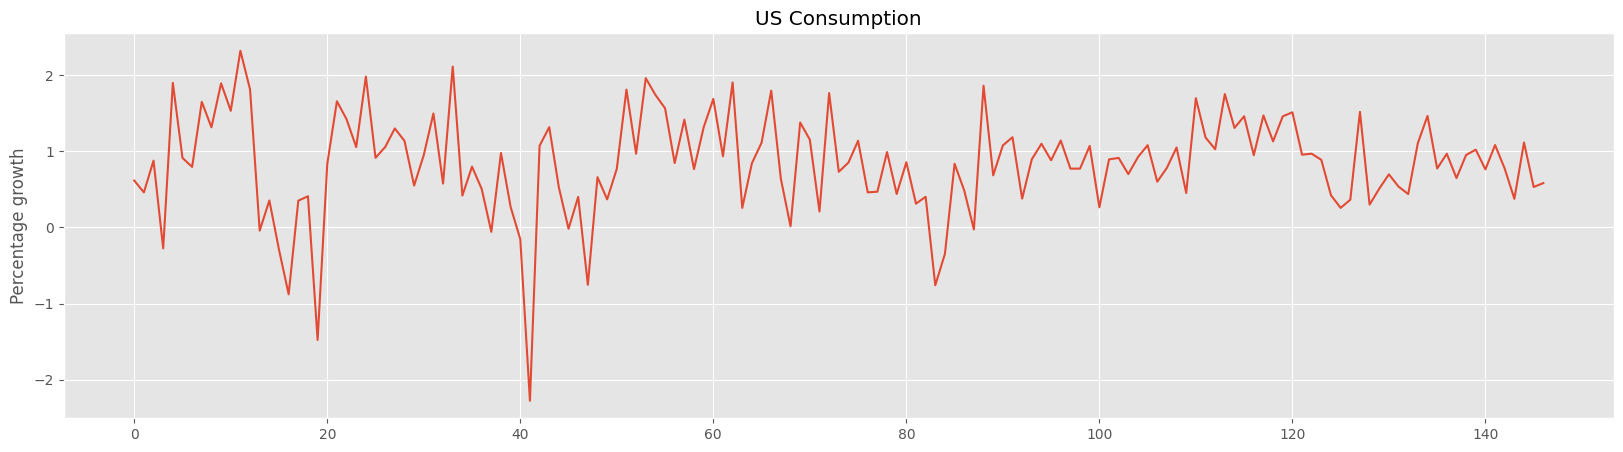

In [16]:

data.loc[:, "ds"] = pd.date_range(start="1970.01.01", periods=len(data), freq="Q")
data["unique_id"] = "1"
data = data.rename(columns={"Consumption": "y"})
y = data.loc[:, ['ds', 'unique_id', 'y']]

horizon = 10 * 4

# Если потребуются мультипликативные модели, необходимо децентрировать данные
# y = y + 10

y_train, y_test = train_test_split(y, shuffle=False, test_size=horizon)

y_train['y'].plot()
plt.title("US Consumption")
plt.ylabel("Percentage growth");

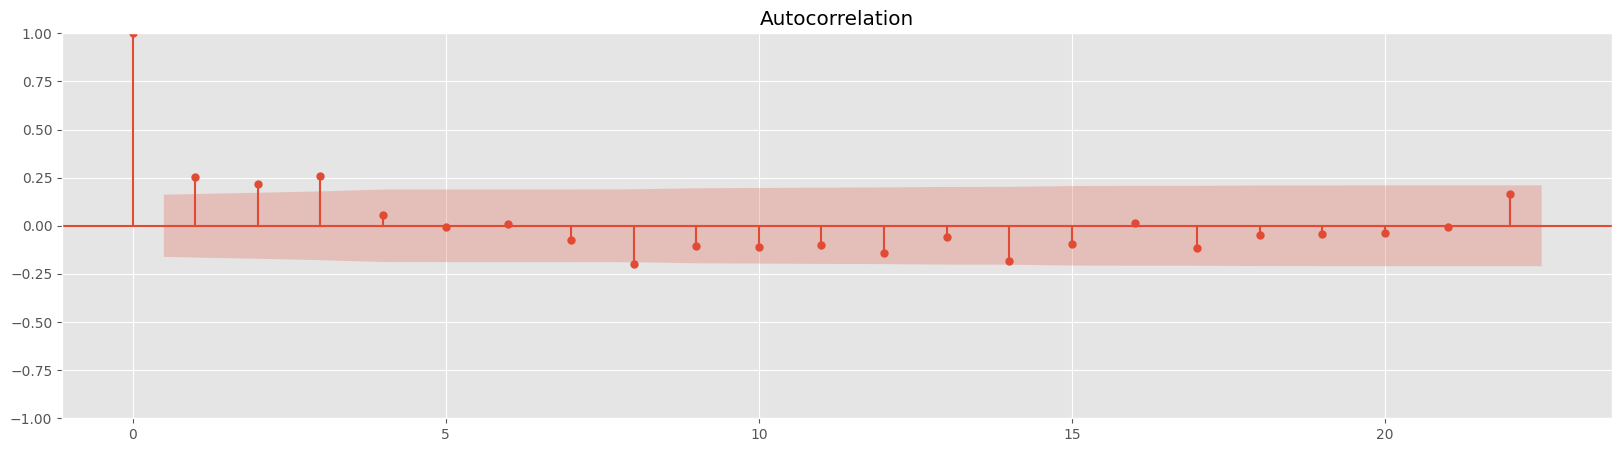

In [17]:
plot_acf(y_train['y']);

Импортируем модели Хольта-Винтерса и ETS. Из последнего семинара мы знаем, что эти модели в целом различаются только метедом оценки, но структурно эквивалентны. Посмотрим на простом примере, а далее будем использовать только ETS, чтобы не дублировать слишком много кода.

In [18]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS

/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


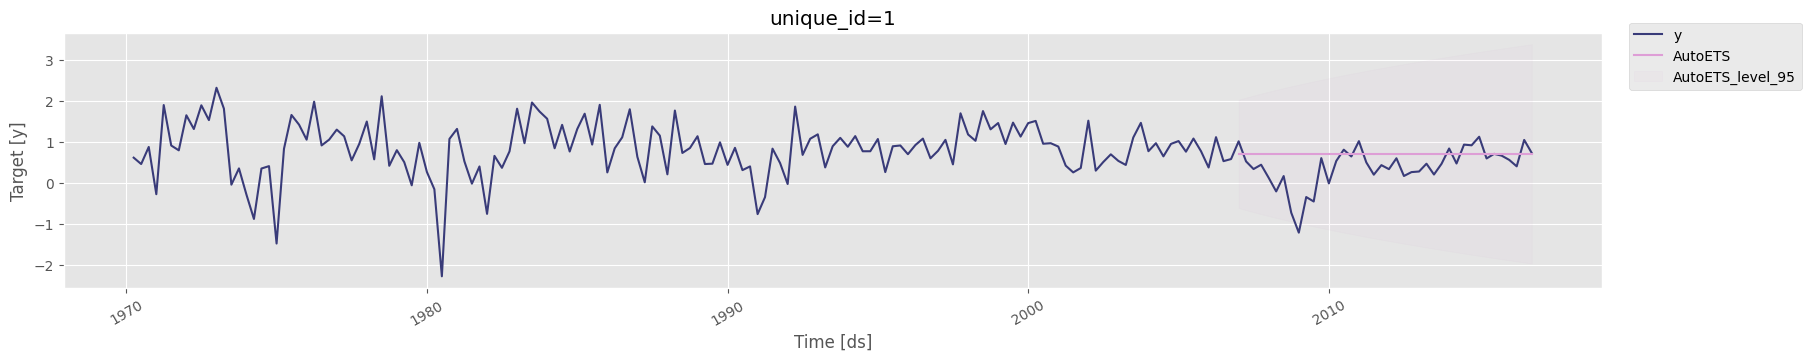

In [19]:
sf = StatsForecast(models=[AutoETS(model="ANN")], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(data, y_hat, level=[95])

In [20]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,0.406052
1,1,mape,2.679850
2,1,mase,0.592440
3,1,rmse,0.565821
4,1,smape,0.352484


/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


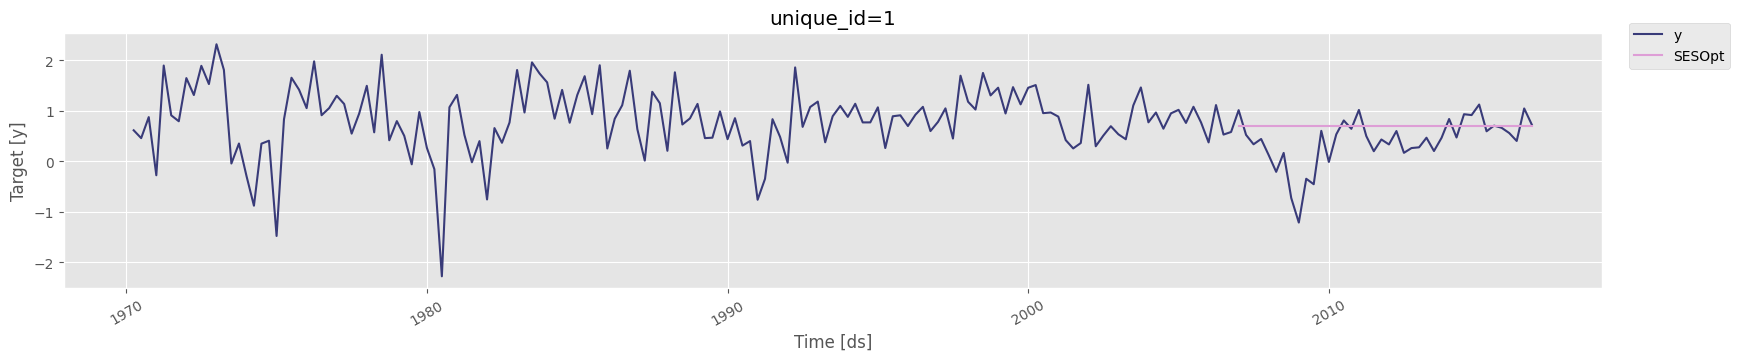

In [21]:
from statsforecast.models import SimpleExponentialSmoothingOptimized

sf = StatsForecast(models=[SimpleExponentialSmoothingOptimized()], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon)
sf.plot(data, y_hat)

# Не сработает, так как модель не стохастическая
# y_hat = sf.predict(h=horizon, level=[95])
# sf.plot(data, y_hat, level=[95])

In [22]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,SESOpt
0,1,mae,0.405459
1,1,mape,2.675028
2,1,mase,0.591575
3,1,rmse,0.565187
4,1,smape,0.352248


In [23]:
sf.fitted_[0,0].model_

{'mean': array([0.70688323]),
 'fitted': array([        nan,  0.61598622,  0.5715929 ,  0.6586614 ,  0.39251736,
         0.82182913,  0.84755148,  0.83242778,  1.06526572,  1.13614657,
         1.35163026,  1.40272012,  1.66391962,  1.705805  ,  1.20725702,
         0.96390298,  0.60571792,  0.18271309,  0.23076146,  0.28178072,
        -0.21963277,  0.08045554,  0.52988721,  0.78365746,  0.86089029,
         1.18014962,  1.10419724,  1.09025423,  1.1497772 ,  1.145954  ,
         0.97592049,  0.96848372,  1.1189753 ,  0.96392892,  1.29123064,
         1.04210061,  0.97244163,  0.83932899,  0.58340504,  0.69577731,
         0.57381593,  0.3662043 , -0.38703724,  0.02917   ,  0.39641122,
         0.43301796,  0.30455423,  0.3322546 ,  0.0226833 ,  0.20432425,
         0.251173  ,  0.39905654,  0.8012235 ,  0.84881072,  1.16566442,
         1.32936939,  1.3962755 ,  1.23908042,  1.28928042,  1.13984416,
         1.18947129,  1.3312812 ,  1.21804844,  1.4133311 ,  1.08332352,
         1.

/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


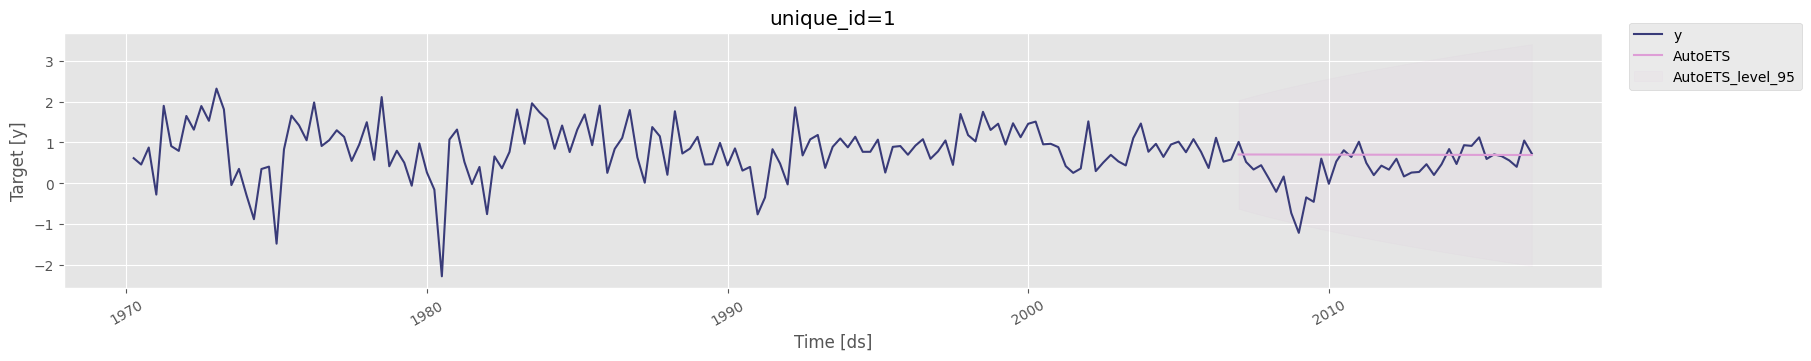

In [24]:
sf = StatsForecast(models=[AutoETS(model="AAN", season_length=4)], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(data, y_hat, level=[95])


In [25]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,0.403264
1,1,mape,2.656679
2,1,mase,0.588373
3,1,rmse,0.563196
4,1,smape,0.351254


Внимательный читатель спросит, мол, как это оценены информационные критерии, у нас же эти модели оцениваются не через правдоподобие. В таком случае можно записать информационные критерии через MSE, а не через правдоподобие. Более того, вариантов записи информационных критериев существует немало, поэтому рекомендуется всегда поглядывать в документацию или потроха пакета.

In [26]:
sf.fitted_[0,0].model_

{'loglik': -306.3942466038785,
 'aic': 622.788493207757,
 'bic': np.float64(637.7406561416507),
 'aicc': 623.2140251226507,
 'mse': np.float64(0.43963810405555387),
 'amse': np.float64(0.48139130407859004),
 'fit': results(x=array([ 2.82857535e-01,  1.09283279e-04,  7.25903440e-01, -3.43095107e-04]), fn=612.788493207757, nit=96, simplex=None),
 'residuals': array([-1.09574127e-01, -2.33835718e-01,  2.49102834e-01, -9.72040942e-01,
         1.47498369e+00,  7.26940287e-02, -6.50315952e-02,  8.07709304e-01,
         2.44586684e-01,  7.53338876e-01,  1.79590619e-01,  9.16453423e-01,
         1.49652607e-01, -1.74519274e+00, -8.55421436e-01, -1.25907841e+00,
        -1.48794844e+00,  1.61641024e-01,  1.74912681e-01, -1.75945726e+00,
         1.04698879e+00,  1.57500674e+00,  8.93507410e-01,  2.76050994e-01,
         1.12385850e+00, -2.59930636e-01, -4.48048262e-02,  2.11643732e-01,
        -1.05666308e-02, -5.93834709e-01, -2.57090939e-02,  5.27953443e-01,
        -5.41695203e-01,  1.14748

Теперь возьмём какие-нибудь трендированные данные.

In [50]:
full_data = macrodata.load_pandas().data
full_data.loc[:, "ds"] = pd.date_range(start="1959.01.01", periods=len(data), freq="Q")
full_data = full_data.drop(columns=['year', 'quarter'])

# Да, для всех рядов одинаковый, но это просто костыль
full_data["unique_id"] = "1"

horizon = 16



/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_13255/497447692.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  full_data.loc[:, "ds"] = pd.date_range(start="1959.01.01", periods=len(data), freq="Q")


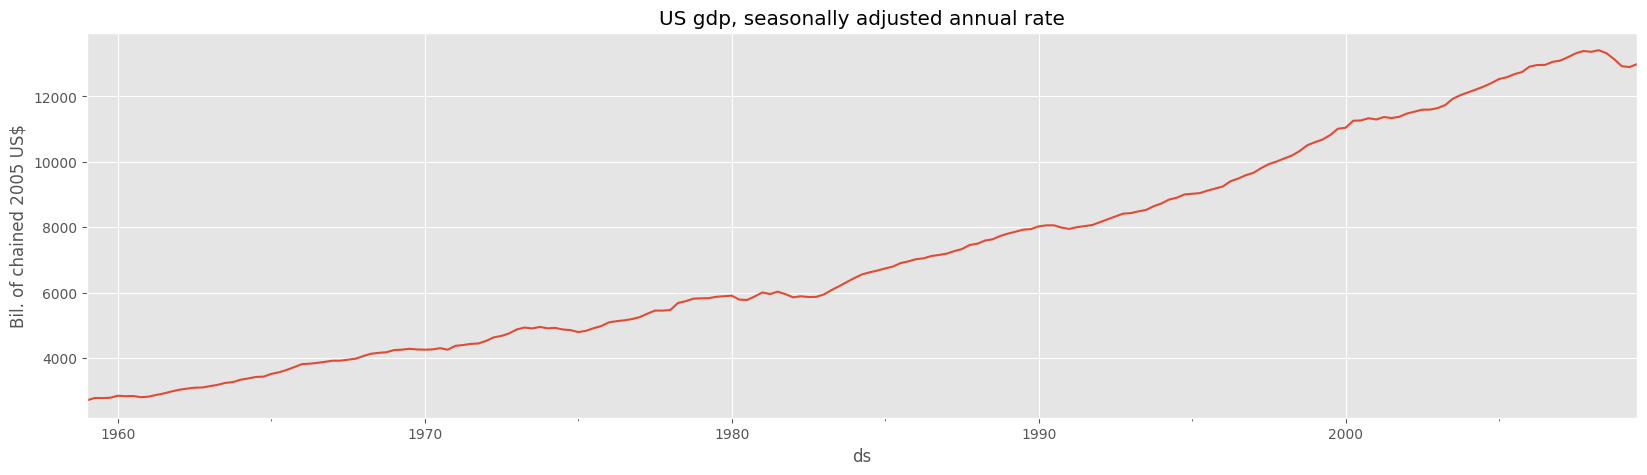

In [52]:

data = full_data[['realgdp', 'ds', 'unique_id']]
y = data.rename(columns={'realgdp': 'y'})
y.set_index('ds')['y'].plot()

plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

y_train, y_test = train_test_split(y, shuffle=False, test_size=horizon)


Text(0, 0.5, 'Bil. of chained 2005 US$')

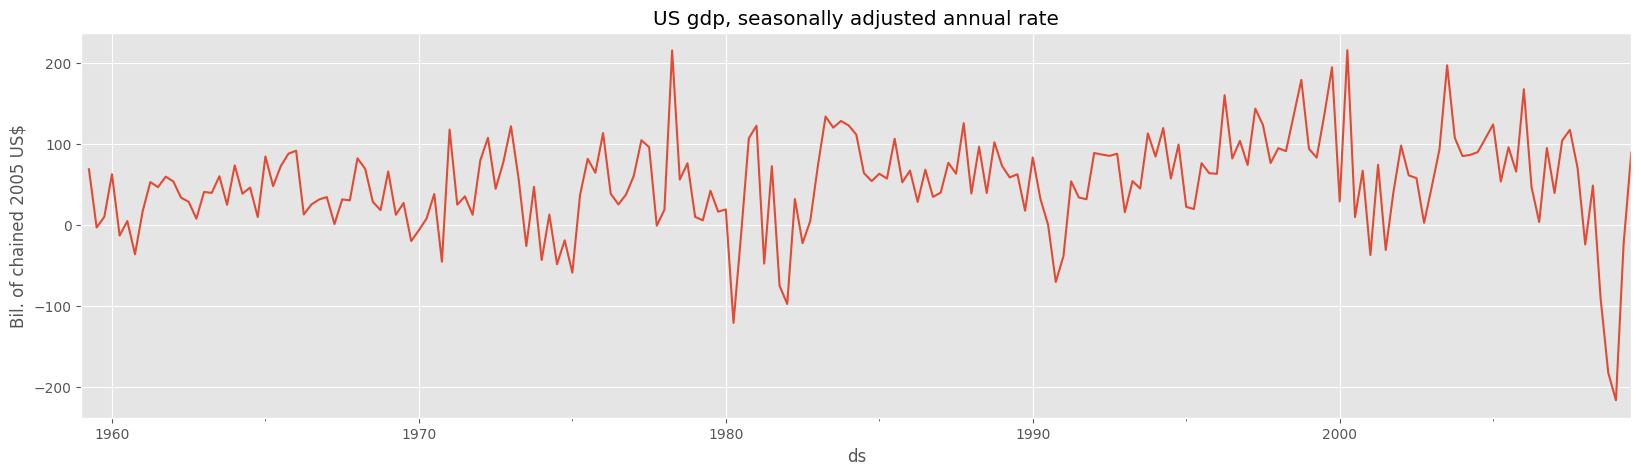

In [54]:
y.set_index('ds')['y'].diff().plot()
plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

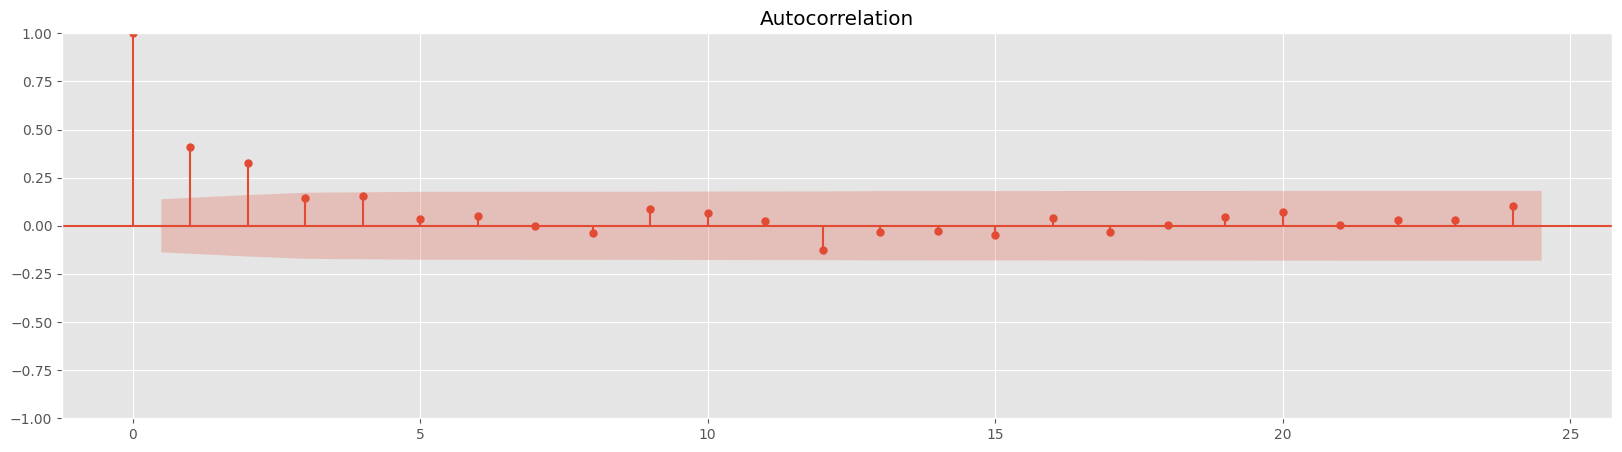

In [55]:
plot_acf(y.set_index('ds')['y'].diff().dropna());

Понятное дело, что здесь уже необходимо применять модель, в которой есть трендовая компонента. Попробуем применить.

/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


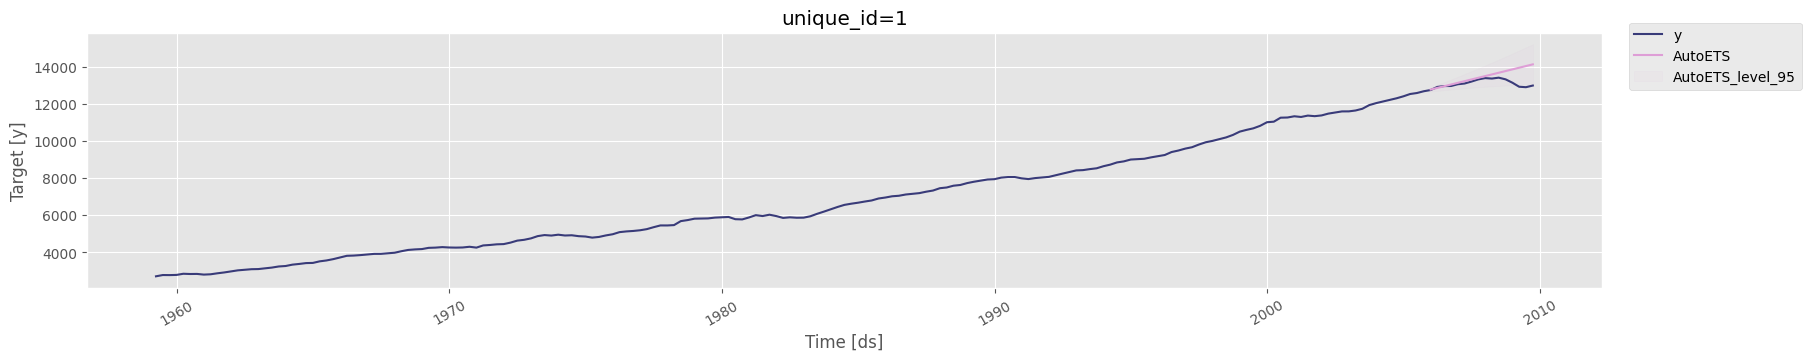

In [57]:
sf = StatsForecast(models=[AutoETS(model="AAN", season_length=4)], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(y, y_hat, level=[95])

In [58]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,352.076285
1,1,mape,0.026964
2,1,mase,0.274461
3,1,rmse,533.633613
4,1,smape,0.013077


Видим явную переоценку тренда. Попробуем дампировать

/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


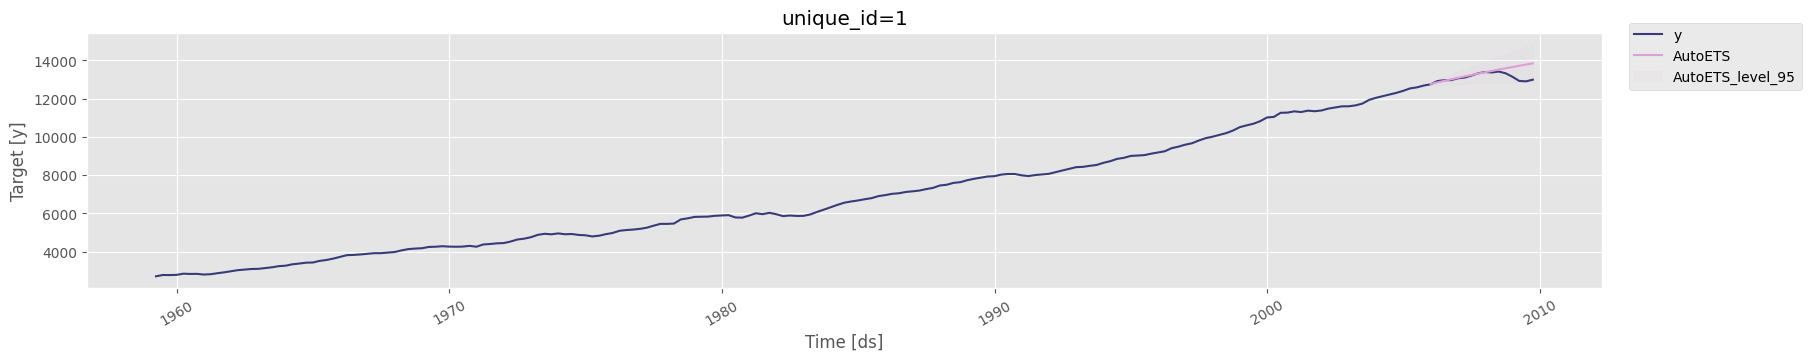

In [59]:
sf = StatsForecast(models=[AutoETS(model="AAN", damped=True, season_length=4)], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(y, y_hat, level=[95])

In [60]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,236.259396
1,1,mape,0.018144
2,1,mase,0.184176
3,1,rmse,393.777099
4,1,smape,0.008850


Мультипликативный тренд, по понятным причинам, ничего особо не изменит, так как тренд затухающий, а не экспоненциальный. Да и дамприование с мультипликативным трендом выглядит несколько противоестественно.

/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


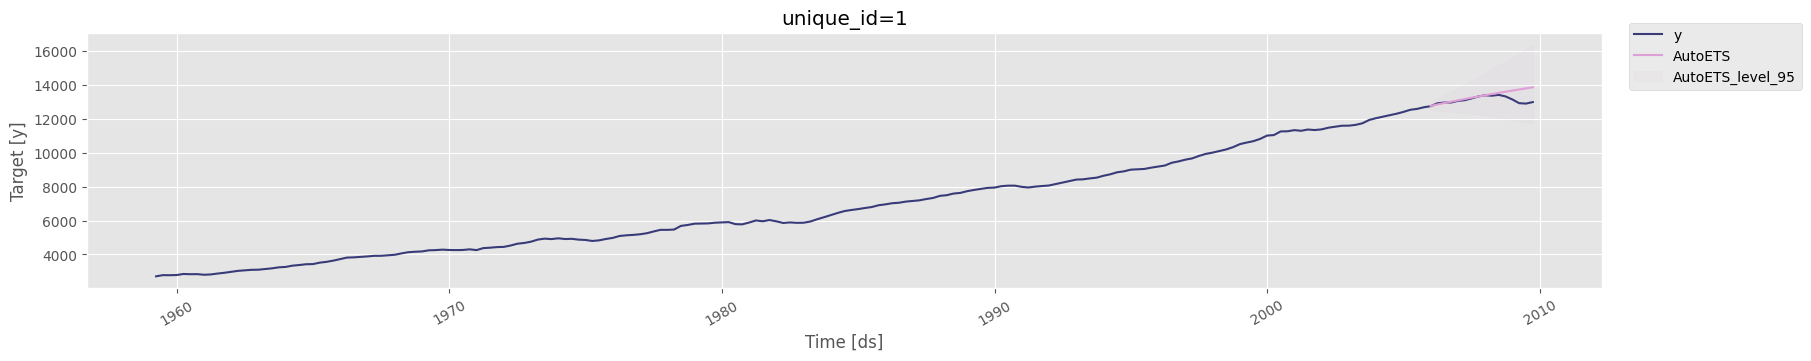

In [62]:
sf = StatsForecast(models=[AutoETS(model="MMN", damped=True, season_length=4)], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(y, y_hat, level=[95])

In [63]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,244.753570
1,1,mape,0.018793
2,1,mase,0.190798
3,1,rmse,405.256443
4,1,smape,0.009161


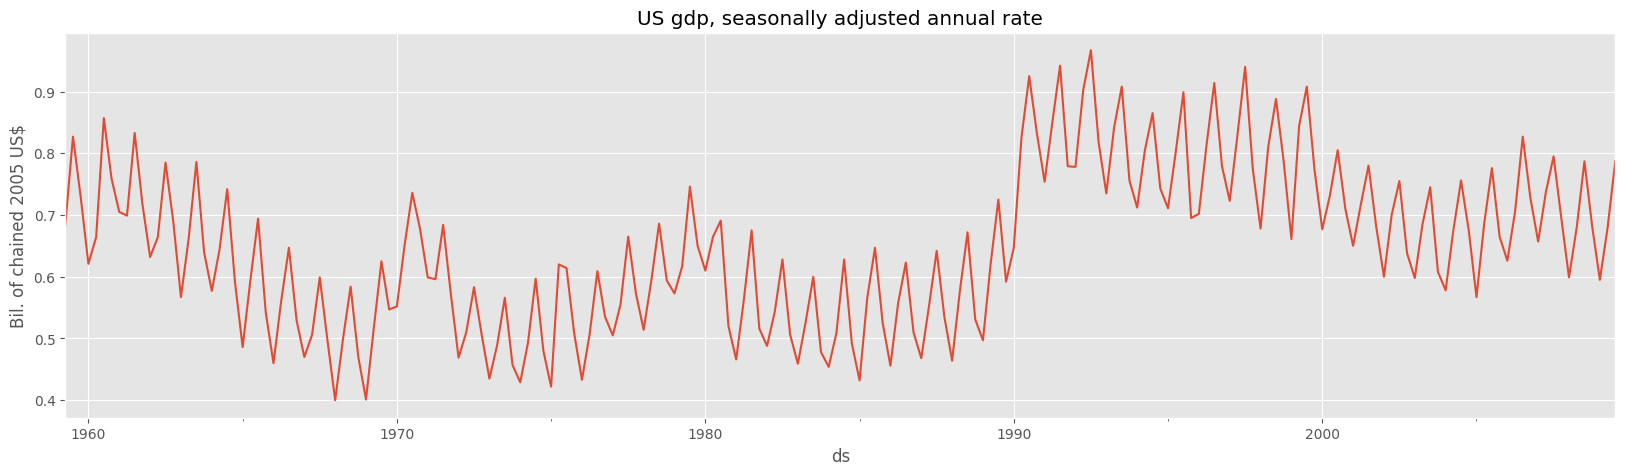

In [67]:

data = full_data[['pop', 'ds', 'unique_id']]
y = data.rename(columns={'pop': 'y'})
y['y'] = y['y'].diff()
y = y.dropna()
y.set_index('ds')['y'].plot()

plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

y_train, y_test = train_test_split(y, shuffle=False, test_size=horizon)


/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/mszekhov/Library/Caches/pypoetry/virtualenvs/hse-ts-course-fT8B7YFo-py3.10/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


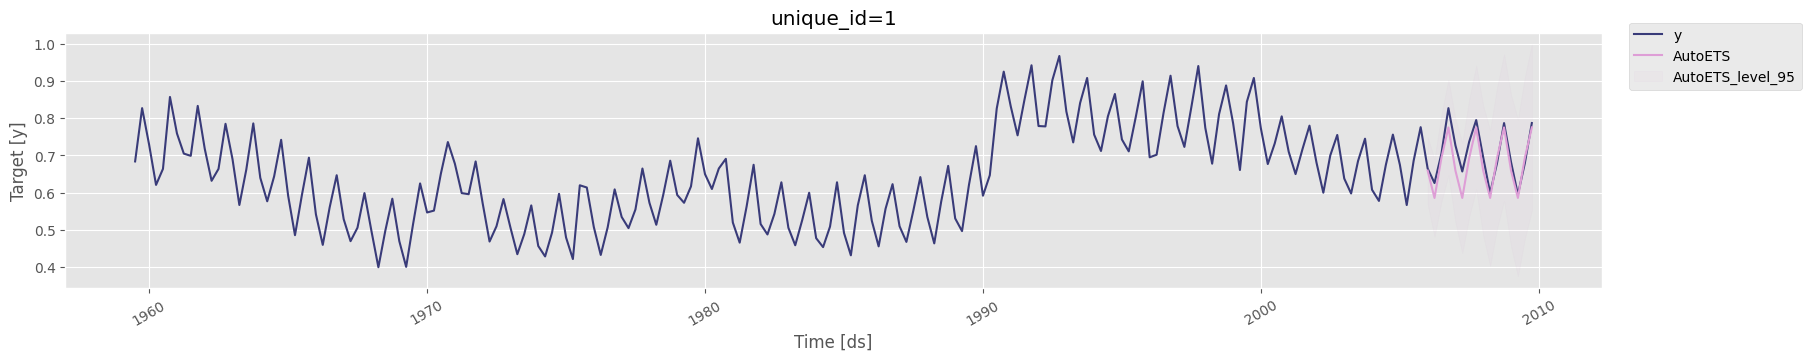

In [68]:
sf = StatsForecast(models=[AutoETS(model="AAA", damped=True, season_length=4)], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(y, y_hat, level=[95])

In [70]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=4), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,0.027659
1,1,mape,0.039288
2,1,mase,0.657955
3,1,rmse,0.034503
4,1,smape,0.020244
